# ucla bioinformatics 2022 written qualifying exam: probabilistic rna-seq outlier detection 
### sandy kim 404830610

In [115]:
library('data.table')
library('nimble')
library('dplyr')
library('biomaRt')
library('rstan')
library('ggplot2')

options(repr.plot.width=10, repr.plot.height=8)

Loading required package: StanHeaders

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



## generative model

In [5]:
gtex_gene_counts <- fread(file="/Users/sandykim/Desktop/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct")

Warning message in fread(file = "/Users/sandykim/Desktop/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct"):
"Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call."


In [3]:
mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl", host = 'https://www.ensembl.org')
genes <- getBM(attributes = c("ensembl_gene_id","external_gene_name", "chromosome_name","transcript_biotype"), filters = c("transcript_biotype","chromosome_name"),values = list("protein_coding",c(1:22)), mart = mart)

In [6]:
gtex_gene_counts$Name <- gsub("\\..*","", gtex_gene_counts$Name)
gtex_gene_counts <- gtex_gene_counts[which(gtex_gene_counts$Name %in% genes$ensembl_gene_id),]
gtex_gene_counts[which(gtex_gene_counts$Name == 'ENSG00000283992'),]$Description = 'SLURP2'

In [7]:
head(gtex_gene_counts)

Name,Description,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000186092,OR4F5,0,2,1,0,1,1,2,0,⋯,4,4,1,3,3,1,2,0,4,0
ENSG00000187634,SAMD11,20,35,14,711,1014,115,1086,152,⋯,777,525,82,157,97,45,30,486,107,13
ENSG00000188976,NOC2L,3839,5237,3660,3040,1797,1722,2818,5149,⋯,3101,3577,3025,2795,3751,2362,3599,3425,5831,2373
ENSG00000187961,KLHL17,508,69,285,999,487,497,719,1566,⋯,627,763,1133,745,715,104,475,496,239,530
ENSG00000187583,PLEKHN1,85,23,60,68,65,63,39,7149,⋯,33,67,28,63,30,21,3678,34,26,24
ENSG00000187642,PERM1,67,1362,108,44,4002,31,145,3056,⋯,2395,33,28,46,84,11,1047,119,6275,16


In [8]:
mus <- data.table(rowMeans(gtex_gene_counts[,3:17384]))
rownames(mus) <- gtex_gene_counts$Description
colnames(mus) <- c('mu')

In [2]:
mus <- fread("gtex_mus.tsv")

Warning message in fread("gtex_mus.tsv"):
"Detected 1 column names but the data has 2 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


In [152]:
set.seed(42)
dispersion <- 100
n_samples <- 1000
n_genes <- 18251
counts <- as.data.frame(matrix(nrow=n_genes, ncol=n_samples))
outlier <- rep(0, times=n_samples)
for (i in (1:n_samples)) {
    outlier[i] <- sample(c(-1, 0, 1), 1, replace = TRUE, prob = c(0.015, 0.97, 0.015))
    counts[,i] <- abs(rnbinom(n_genes, size = dispersion, mu = mus$mu) + outlier[i] * rnbinom(n_genes, size = dispersion, mu = mus$mu * 0.01251))
}
counts <- abs(counts)
rownames(counts) <- mus$V1

In [104]:
# sf <- DESeq2::estimateSizeFactorsForMatrix(counts)
# counts <- t(t(counts)/sf)

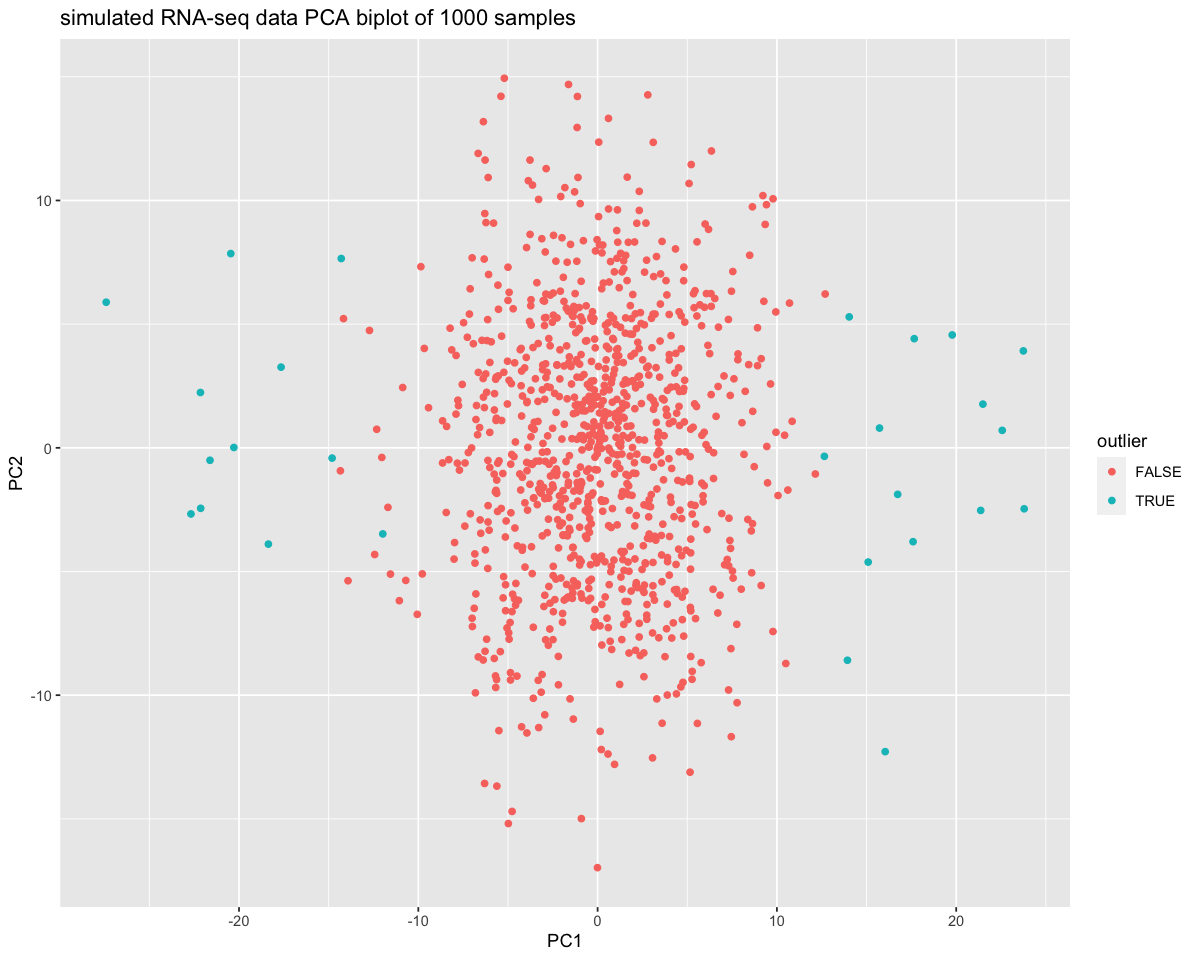

In [153]:
counts <- counts[which(apply(counts, 1, var) != 0),]
pca_counts <- prcomp(t(counts), center=TRUE, scale=TRUE)
pca_counts$x <- data.frame(pca_counts$x, outlier)
p <- ggplot(data=data.frame(pca_counts$x)) + geom_point(aes(x=PC1, y=PC2, color=as.logical(outlier))) + labs(title = "simulated RNA-seq data PCA biplot of 1000 samples", color = "outlier")
p

## inference model

In [71]:
delta <- 0
n_samples <- 1000
n_genes <- 18251
psi <- rep(0, times=n_samples)
outlier <- rep(0, times=n_samples)
log_outlier_effect <- rep(0, times=n_samples)
mean_counts <- mus$mu
m <- matrix(nrow=n_genes, ncol=n_samples)
p <- matrix(nrow=n_genes, ncol=n_samples)
r <- matrix(nrow=n_genes, ncol=n_samples)
x <- matrix(nrow=n_genes, ncol=n_samples)

In [78]:
pi <- rbeta(1, 3, 60)
sigma <- rgamma(1, 1, 0.1)
phi <- rgamma (1, 1, 1)
tau <- rgamma(1, 1, 0.1)
phi_genes <- rgamma(n_genes, phi, 1)

for (n in 1:n_samples) {
    psi[n] <- rbinom(1, 1, pi)
    outlier[n] <- rnorm(1, 0, sigma)
    log_outlier_effect[n] <- 2^(psi[n] * dnorm(outlier[n], tau) + (1- psi[n]) * delta)
}
for (i in (1:n_genes)) {
    phi_gene[g] <- rgamma(1, phi, 1)
    for (n in 1:n_samples) {
        r[g,n] <- phi_gene[g]
        m[g,n] <- mean_counts[g] * log_outlier_effect[n]
        x[g,n] <- rnbinom(1, m[g,n], r[g,n])
    }
}

In [154]:
model_data = list(
  n_samples = ncol(counts),
  n_genes = nrow(counts),
  counts = counts,
  psi = abs(outlier),
  mean_counts = apply(counts, 1, mean)
)

In [155]:
fit = stan(
  file = 'wqe.stan',
  data = model_data,
  chains = 2,
  warmup = 500,
  iter = 1000
)

Warning message in readLines(file, warn = TRUE):
"incomplete final line found on '/Users/sandykim/Desktop/wqe.stan'"
